# Notes on Coding Tasks

* data will be published tonight / tomorrow on the excercise webpage)
* you will get 2 files: one for training (contains labels), one for evaluation (does not contain labels)
* for evaulation, upload your predictions in the same format as the download 
    * each data sample in a file has a unique id
        * upload only the data sample id and your predicted label
        * don't upload the input data (there is a size limit for each upload)
* format: JSON
    * python has built-in functionallity to read / write JSON
    * if you never used it (with python), there is a short overview: https://realpython.com/python-json/


### NLU train data

```
{
    "0": {
        "intent": "AddToPlaylist",
        "text": "Add a tune to my elrow Guest List",
        "slots": {
            "music_item": "tune",
            "playlist_owner": "my",
            "playlist": "elrow Guest List"
        },
        "positions": {
            "music_item": [
                6,
                9
            ],
            "playlist_owner": [
                14,
                15
            ],
            "playlist": [
                17,
                32
            ]
        }
    },
    "1": {
        "intent": "AddToPlaylist",
        "text": "Add a guy is a guy to the infinite indie folk playlist.",
        "slots": {
            "entity_name": "a guy is a guy",
            "playlist": "infinite indie folk"
        },
        "positions": {
            "entity_name": [
                4,
                17
            ],
            "playlist": [
                26,
                44
            ]
        }
    },
...
    ```
    
**Upload your predictions without "text" and "position" fields!**

### Emotion train data

`features`-entry contains a list of a list with 26 items.
* length of inner list: 26 (float numbers - represent one preprocessed speech frame (logMel))
* length of outer list: number of frames per data-point, e.g. 10 or 15, ...
* for easy parsing into an array, have a look at e.g. https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.fromstring.html

```
{"0": {"valence": 0, 
       "activation": 1,
       "features": [[5.502810676891276, 5.389630715979907, 5.89079939835461, 5.462222408074205, 5.482823967430299, 6.776999420417389, 7.500191549370183, 8.304382413190043, 8.01058604345238, 6.033706406358724, 7.067212416470815, 6.4463667723745965, 6.923879604046541, 8.091544891207468, 7.972158444902915, 7.641215050710871, 7.1507373690379525, 7.507756141316357, 7.074741477204279, 7.992954055443716, 7.576059013864094, 7.7207549746760975, 8.649263126832178, 8.220149828892483, 6.811228837696475, 6.457873509412178], [...], ...]
       },
 "1: "valence": 1, 
       "activation": 1,
       "features": [[3.502810676891276, 5.389630715979907, 5.89079939835461, 5.462222408074205, 5.482823967430299, 6.776999420417389, 7.500191549370183, 8.304382413190043, 8.01058604345238, 6.033706406358724, 7.067212416470815, 6.4463667723745965, 2.923879604046541, 8.091544891207468, 7.972158444902915, 7.641215050710871, 7.1507373690379525, 7.507756141316357, 7.074741477204279, 7.992954055443716, 7.576059013864094, 7.7207549746760975, 8.649263126832178, 8.220149828892483, 6.811228837696475, 6.457873509412178], [...], ...]
       },
       ...
```

**Upload your predictions without "features" fields!**

# Tensorflow 2 / Keras Tutorial

* Tensorflow allows you to perform tensor calculations
* great benefits:
    * automatic differentiation
    * move data to GPU -> faster calculation for large amounts of data

Difference to pytorch?
<img src="dlframeworks.png" width="300px"/>
(found on https://me.me/)

## First steps
Install tensorflow (CPU-only): `pip install tensorflow`

or for GPU (requires CUDA >= 10.0): `pip tensorflow-gpu`

In [14]:
import tensorflow as tf
import numpy as np

## Tensors

Tensors can be created in a number of ways:

* from numpy arrays
* from lists
* using tensorflow functions
    * e.g. `tf.ones`, `tf.zeros`, ...
    * also, calculation functions convert to tf tensors automatically: `tf.add`, ...

In [15]:
import numpy as np
import tensorflow as tf

# create a numpy array
a = np.array([1,2,3])
print(f"type of a: {type(a)}")

# create tensor of zeros
b = tf.zeros((3,))
print(f"type of b: {type(b)}")

# automatic conversion to tensor
c = tf.add(a,b)
print(f"type of c: {type(c)}")

# print contents
print(c)

type of a: <class 'numpy.ndarray'>
type of b: <class 'tensorflow.python.framework.ops.EagerTensor'>
type of c: <class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor([1. 2. 3.], shape=(3,), dtype=float32)


Now the cool stuff - automatic differentiation!
To tell tensorflow to record changes to variables, you need a `GradientTape`.
It records the changes to variables "on a tape".
This tape can then be queried for gradients.

Let's differentiate $y = x*2 + z$ w.r.t $x, z \in \mathbb{R}^3$

In [16]:
x = tf.ones((3,))
z = tf.ones((3,))

with tf.GradientTape(persistent=True) as t:
    t.watch((x,z))
    y = x*2 + z
    print("y", y)
print(f"dy/dx = {t.gradient(y,x)}, dy/dz = {t.gradient(y,z)}")

y tf.Tensor([3. 3. 3.], shape=(3,), dtype=float32)
dy/dx = [2. 2. 2.], dy/dz = [1. 1. 1.]


That is the first step on getting a trainable model - now that we can calculate gradients,
we can try building and training our first linear layers - with one tensor for the weights and one for the bias.

Tensors are, however, immutable - we actually want to adapt our weights by gradient descent over time.
This is where *Variables* come in. They are essentially mutable tensors.

In [17]:
# create tensor of ones
x = tf.Variable(tf.ones((3,)))
print(x)

# add tensor of ones, thereby changing the state of x
x.assign_add(tf.ones((3,)))
print(x)

<tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([1., 1., 1.], dtype=float32)>
<tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([2., 2., 2.], dtype=float32)>


Now we have everything to build our own linear layer with sigmoid activation

$f(\mathbf{x}) = \sigma(\mathbf{W}\mathbf{x} + \mathbf{b})$

and a square loss function

$loss(y,\hat{y}) = (y-\hat{y})^2$

In [34]:
def se_loss(y_hat, y):
    loss = tf.square(y_hat-y)  # (y^ - y)^2
    return loss

class Perceptron:
    def __init__(self, in_size: int, out_size: int):
        # randomly initialize weights
        self.W = tf.Variable(np.random.sample((out_size, in_size)), dtype=tf.float32)  # insize x outsize
        self.b = tf.Variable(np.random.sample((out_size, 1)), dtype=tf.float32)        # outsize
        self.activation = tf.sigmoid
        
    def __call__(self, x):
        # forward pass 
        Wx = tf.matmul(self.W, x)
        z = tf.add(Wx, self.b)
        y = self.activation(z)
        return y
    
    

def loss_and_grads(model, x, y, print_stuff=False):
    with tf.GradientTape() as t:
        y_hat = model(x)
        loss = se_loss(y_hat, y)
        
    dW, db = t.gradient(loss, [model.W, model.b])
    if print_stuff:
        print("forward pass: sigmoid(Wx + b) = ", y_hat)
        print("loss: ", loss)
        print("backward pass:")
        print("dloss/dW = ", dW)
        print("dloss/db = ", db)
    return y_hat, loss, (dW, db)
    

l = Perceptron(in_size=4, out_size=1)
x = tf.ones((4,1))
y = tf.ones((1,))
y_hat, loss, t = loss_and_grads(l, x, y, print_stuff=True)

forward pass: sigmoid(Wx + b) =  tf.Tensor([[0.94996727]], shape=(1, 1), dtype=float32)
loss:  tf.Tensor([[0.00250327]], shape=(1, 1), dtype=float32)
backward pass:
dloss/dW =  tf.Tensor([[-0.00475606 -0.00475606 -0.00475606 -0.00475606]], shape=(1, 4), dtype=float32)
dloss/db =  tf.Tensor([[-0.00475606]], shape=(1, 1), dtype=float32)


## Training your first neural network

**Our problem:** 
Ever since Grumpy Cat became internet famous, he has been put on millions of memes.
As you can imagine, there is a huge amount of requests for him to judge events as being either nice or horrible.
Grumpy Cat is sick of dealing with each request manually and wants us to build a very sophisticated classifier for this task using neural networks (being a lot on the internet, Grumpy Cat knows what the latest hype is about).

<img src="https://i2.wp.com/metro.co.uk/wp-content/uploads/2019/05/SEI_67888770.jpg?quality=90&strip=all&zoom=1&resize=540%2C405&ssl=1"/>
(https://i2.wp.com/metro.co.uk/wp-content/uploads/2019/05/SEI_67888770.jpg?quality=90&strip=all&zoom=1&resize=540%2C405&ssl=1)

So we ask Grumpy Cat for some example data points in the form of $(x,y)$. 
x refers to Grumpy Cat's observations, y to his rating.

where x = (
           # mondays in sentence, 
           # references to a movie, 
           grumy cat had breakfast (0 or 1), 
           # humans grumpy cat has seen today
           )
and $y = 0$ if nice, $y=1$ if horrible.

Grumpy cat then concatenates all samples into a dataset $(X,Y)$:
$X \in \mathbb{R}^{n \times 4}, Y \in \mathbb{R}^{n \times 1} $

In [35]:
num_samples = 1000

num_mondays = np.random.randint(low=0, high=10, size=(num_samples,))
num_references = np.random.randint(low=0, high=10, size=(num_samples,))
had_breakfast = np.random.randint(low=0, high=2, size=(num_samples,))
num_humans = np.random.randint(low=0, high=50, size=(num_samples,))

# create X by concatenating features column-wise
X = np.stack([num_mondays, num_references, had_breakfast, num_humans], axis=1)
print("X shape:", X.shape)
for i in range(5):
    print(f"mondays: {X[i,0]}, movies: {X[i,1]}, breakfast: {bool(X[i,2])}, humans: {X[i,3]}")
    
# create Y:
Y = np.random.randint(low=1, high=2, size=(num_samples, )) # everything is horrible!
print("Y shape: ", Y.shape)

X shape: (1000, 4)
mondays: 8, movies: 1, breakfast: True, humans: 27
mondays: 7, movies: 5, breakfast: True, humans: 37
mondays: 0, movies: 4, breakfast: False, humans: 12
mondays: 6, movies: 0, breakfast: False, humans: 13
mondays: 8, movies: 0, breakfast: True, humans: 2
Y shape:  (1000,)


initial bias: <tf.Variable 'Variable:0' shape=(1, 1) dtype=float32, numpy=array([[0.26318178]], dtype=float32)>
intial weights: <tf.Variable 'Variable:0' shape=(1, 4) dtype=float32, numpy=array([[0.9709684 , 0.17693357, 0.0698963 , 0.45808178]], dtype=float32)>
epoch 0 loss: 0.00013428535021375865
epoch 1 loss: 5.184162000659853e-05
epoch 2 loss: 3.506531356833875e-05
epoch 3 loss: 2.665461943252012e-05
epoch 4 loss: 2.1562225811067037e-05
trained bias <tf.Variable 'Variable:0' shape=(1, 1) dtype=float32, numpy=array([[0.50272363]], dtype=float32)>
trained weights <tf.Variable 'Variable:0' shape=(1, 4) dtype=float32, numpy=array([[1.026868  , 0.7149183 , 0.25046566, 0.711131  ]], dtype=float32)>


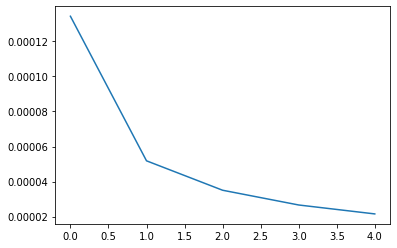

In [38]:
import matplotlib.pyplot as plt
import random

alpha = 0.5
perceptron = Perceptron(in_size=4, out_size=1)
print("initial bias:", perceptron.b)
print("intial weights:", perceptron.W)

losses = []
for epoch in range(5):
    epoch_loss = []
    shuffled_indices = list(range(X.shape[0]))
    random.shuffle(shuffled_indices)
    for i in shuffled_indices:
        # forward & backward pass (just draw radom x, try to map all inputs to 1)
        x = tf.convert_to_tensor(X[i,:].reshape(4,1), dtype=tf.float32)
        y = tf.convert_to_tensor(Y[i], dtype=tf.float32)
        
        y_hat, loss, (dW, db) = loss_and_grads(perceptron, x, y)

        # apply gradients from backward pass
        perceptron.W.assign_sub(alpha * dW)
        perceptron.b.assign_sub(alpha * db)

        epoch_loss.append(loss[0,0])
    print(f"epoch {epoch} loss: {sum(epoch_loss) / len(epoch_loss)}")
    losses.append(sum(epoch_loss) / len(epoch_loss))

plt.plot(losses)
print("trained bias", perceptron.b)
print("trained weights", perceptron.W)

Let's try some predictions (remember: 0 is nice, 1 is grumpy):

In [40]:
def predict(x):
    y_hat = perceptron(x)
    return y_hat
    
print(predict([[10.],[10.],[0.],[10.]]))
print(predict([[5.],[3.],[1.],[8.]]))
print(predict([[2.],[5.],[0.],[4.]]))

tf.Tensor([[1.]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9999989]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9998735]], shape=(1, 1), dtype=float32)


We present our model to grumpy cat, and, suprisingly, he thinks we did a woeful job.

<img width="450px" src="https://pm1.narvii.com/5788/b89a6d573c478bd8c4c17328ab101c8a08f4e84e_hq.jpg"/>
(https://pm1.narvii.com/5788/b89a6d573c478bd8c4c17328ab101c8a08f4e84e_hq.jpg")


According to him, our approach is flawed in multiple ways:
* potentially unstable (fixed learning rate, no averaging across multiple samples - high gradient variance)
* inefficient (no batching)


As is customary with cats, grumpy changed his mind - he now wants us to do multi-class classification: $y \in \{$ nice, bad, very bad $\}$!


Also, Grumpy recently heard of "deep" learning and is afraid that our model is too shallow to be trendy anymore.


**Phew, that would be a large amount of work to modify our model!**

Keras to the rescue!

Let's first re-build our current Model with Keras.

We will make use of the following functionallity
* tf.keras.Sequential module: a list of network layers
* tf.keras.layers.Dense: a linear layer with activation of your choosing
* compile(): create your model with optimizer and loss function
* fit(): train on input data and labels for the specified amount of epochs
* history: keras records training statistics for us

Train on 1000 samples
Epoch 1/5
1000/1000 [==============================] - 1s 746us/sample - loss: 3.9864e-04
Epoch 2/5
1000/1000 [==============================] - 1s 611us/sample - loss: 1.2651e-04
Epoch 3/5
1000/1000 [==============================] - 1s 619us/sample - loss: 9.6987e-05
Epoch 4/5
1000/1000 [==============================] - 1s 621us/sample - loss: 7.8165e-05
Epoch 5/5
1000/1000 [==============================] - 1s 624us/sample - loss: 6.5075e-05


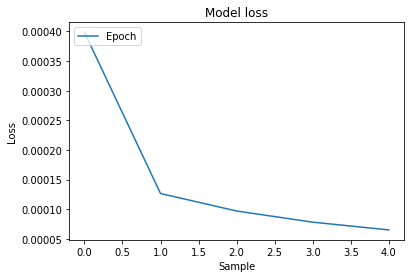

In [103]:
import tensorflow as tf
import tensorflow.keras as keras


perceptron = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation="sigmoid")
])
perceptron.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.5),
              loss=keras.losses.MeanSquaredError())
train_history = perceptron.fit(X, Y, epochs=5, batch_size=1)

# Plot training loss values
plt.plot(train_history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

We can improve stability & performance by batching (processing multiple data points at the same time -> averaging  the gradients across one mini-batch instead of one sample -> stability).

That means, we append a batch dimension ($b \in \mathbb{N}^{+}$) to our tensors:
    
$x \in \mathbb{R}^4 \rightarrow x \in \mathbb{R}^{b \times 4}$ 

and

$y \in \mathbb{R} \rightarrow y \in \mathbb{R}^{b \times 1}$

In Keras, we can specify the batch size simply by appending it to the compile() arguments.

Train on 1000 samples
Epoch 1/5
1000/1000 [==============================] - 0s 180us/sample - loss: 0.0044
Epoch 2/5
1000/1000 [==============================] - 0s 29us/sample - loss: 0.0011
Epoch 3/5
1000/1000 [==============================] - 0s 30us/sample - loss: 6.7186e-04
Epoch 4/5
1000/1000 [==============================] - 0s 23us/sample - loss: 5.3000e-04
Epoch 5/5
1000/1000 [==============================] - 0s 25us/sample - loss: 4.5199e-04


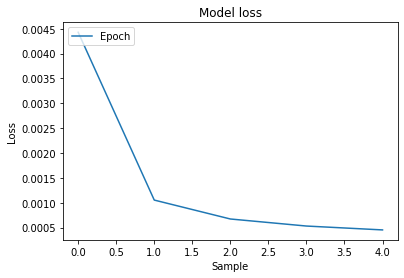

In [104]:
perceptron = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation='sigmoid')
])
perceptron.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.5),
              loss=keras.losses.MeanSquaredError(), batch_size=16)
train_history = perceptron.fit(X,Y, epochs=5)


# Plot training loss values
plt.plot(train_history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

Now, the last change Grumpy Cat demanded of us:
More layers and multi-class classification!

As you learned in your last excercise, we will expand the network to output 1 number per class,
apply softmax instead of sigmoid and finally swap our loss function to *CrossEntropy*.

label shape: (1000,)


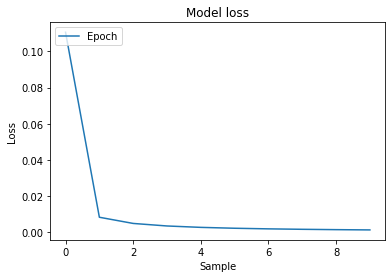

In [9]:
multiClassModel = tf.keras.Sequential([
    tf.keras.layers.Dense(3, activation='sigmoid'),
    tf.keras.layers.Dense(3, activation='softmax')
])
multiClassModel.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.5),
              loss='categorical_crossentropy', batch_size=16)

Y_multiClass = np.zeros((X.shape[0], 3))
Y_multiClass[:,2] = 1
train_history = multiClassModel.fit(X,Y_multiClass, epochs=10, verbose=0)


# Plot training loss values
plt.plot(train_history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Sample')
plt.legend(['Train'], loc='upper left')
plt.show()

We can use keras not only to train, but also to predict:

In [10]:
import tensorflow.keras as keras
import matplotlib.pyplot as plt
print(multiClassModel.predict(X[0,:].reshape(1,4)))
print(multiClassModel.predict([[5.,3.,1.,8.]]))
print(multiClassModel.predict([[2.,5.,0.,4.]]))

[[0.00209901 0.00467763 0.9932234 ]]
[[4.6960931e-04 4.0353127e-04 9.9912685e-01]]
[[4.8860622e-04 4.3201671e-04 9.9907935e-01]]


To see our model architecture in more human-readable form, we can use the *summary()* function

In [12]:
print(multiClassModel.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  15        
_________________________________________________________________
dense_1 (Dense)              multiple                  12        
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
None


Best practices:
* Split your dataset into training, development and test datasets
    * train on training set
    * tune your model on development set
    * test your model on test set
        * only then do you have an estimate how well your model works on unseen data
        * **never use test set for training or tuning!**

Using a development set during training in Keras is easy:
either provide `validation_data` to the fit function or 
provide the fraction of your training set to be used as validatiton data via `validation_split` $\in [0,1)$

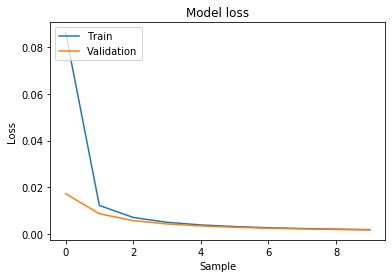

In [50]:
multiClassModel = tf.keras.Sequential([
    tf.keras.layers.Dense(3, activation='sigmoid'),
    tf.keras.layers.Dense(3, activation='softmax')
])
multiClassModel.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.5),
              loss='categorical_crossentropy', batch_size=16)

Y_multiClass = np.zeros((X.shape[0], 3))
Y_multiClass[:,2] = 1
train_history = multiClassModel.fit(X,Y_multiClass, epochs=10, verbose=0, validation_split=0.3)

# Plot training and development loss values
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Sample')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

For testing, Keras comes with the `evaluate()`-function

In [ ]:
train_history = multiClassModel.evaluate(X,Y_multiClass)

For a classifier, you might also be interested in the accuracy:

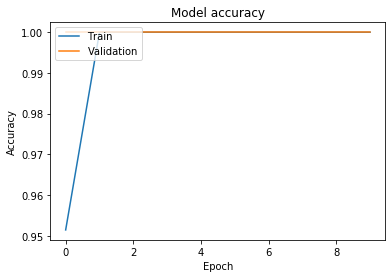

In [57]:
multiClassModel = tf.keras.Sequential([
    tf.keras.layers.Dense(3, activation='sigmoid'),
    tf.keras.layers.Dense(3, activation='softmax')
])
multiClassModel.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.5),
              loss='categorical_crossentropy', batch_size=16, metrics=['accuracy'])

Y_multiClass = np.zeros((X.shape[0], 3))
Y_multiClass[:,2] = 1
history = multiClassModel.fit(X,Y_multiClass, epochs=10, verbose=0, validation_split=0.3)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Creating custom keras models

Instead of using `keras.Sequential`, we can also write our own model class by inheriting from `keras.Model`:

In [ ]:
class FancyClassifier(tf.keras.Model):
  def __init__(self):
    super(FancyClassifier, self).__init__()
    self.d1 = keras.layers.Dense(4, activation='relu')
    self.d2 = keras.layers.Dense(4, activation='relu')
    self.out = keras.layers.Dense(1, activation='sigmoid')

  def call(self, x):
    x = self.d1(x)
    x = self.d2(x)
    return self.out(x)
model = FancyClassifier()

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              loss=keras.losses.MeanSquaredError())

Training is also just calling `model.fit(...)`
You can also pass custom loss functions, etc.

If you want to evaluate your model on some test dataset
(like fit without training, but including metrics),
you can use `evaluate()`:

<img src="https://scontent-frt3-2.xx.fbcdn.net/v/t1.0-9/42796029_465114587315960_6550463706432536576_n.jpg?_nc_cat=101&_nc_oc=AQlWzG0jGpz36Z_x7h391LLQYucyjLi-bKAQVeB1FRlZhqRakSaOO-1wJMa81Z2QK6zqfISwlEy4YgscK6dmiUOr&_nc_ht=scontent-frt3-2.xx&oh=8df7c6e743ea7faf549f82cb949e1e55&oe=5E42E014"/>
(https://scontent-frt3-2.xx.fbcdn.net/v/t1.0-9/42796029_465114587315960_6550463706432536576_n.jpg?_nc_cat=101&_nc_oc=AQlWzG0jGpz36Z_x7h391LLQYucyjLi-bKAQVeB1FRlZhqRakSaOO-1wJMa81Z2QK6zqfISwlEy4YgscK6dmiUOr&_nc_ht=scontent-frt3-2.xx&oh=8df7c6e743ea7faf549f82cb949e1e55&oe=5E42E014)